In [1]:
import sys

sys.path.append("../src")

import numpy as np
import librosa
import matplotlib.pyplot as plt
import torch
import IPython.display as ipd
import soundfile as sf

from net.eff import EfficientNet

In [2]:
ckpt_path = "../logs/dev_fma-s_wav-22050_logfreq/v1/fit3/checkpoints/best-epoch=80-val_loss=0.0254.ckpt"
ckpt = torch.load(ckpt_path, map_location="cpu")
net = EfficientNet()
weights = {k[4:]: v for k, v in ckpt["state_dict"].items()}
net.load_state_dict(weights)

/home/user/.pyenv/versions/3.9.10/envs/audio-env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/.pyenv/versions/3.9.10/envs/audio-env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [3]:
wav, sr = librosa.load("../data/flat.mp3", sr=22050)
print(wav.shape, sr)
ipd.display(ipd.Audio(wav, rate=sr))
# trunc_wav = wav[sr * 3 : sr * 6]
trunc_wav = wav
ipd.display(ipd.Audio(trunc_wav, rate=sr))

(361728,) 22050


(1025,)


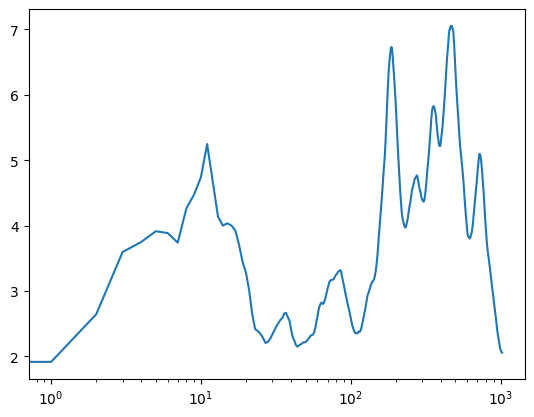

In [7]:
spec = librosa.stft(trunc_wav)
magspec = np.abs(spec).astype(np.float32)
magspec = torch.tensor(magspec)
eq = net(magspec[None, None, ...])
eq = eq[0].detach().numpy()
eq = np.power(10, eq)
print(eq.shape)
plt.plot(eq)
plt.xscale("log")
plt.show()

In [8]:
full_spec = librosa.stft(wav)
restore_spec = eq[:, None] * full_spec
restore_wav = librosa.istft(restore_spec)
ipd.display(ipd.Audio(restore_wav, rate=sr))
restore_wav = librosa.util.normalize(restore_wav)
sf.write("restore.wav", restore_wav, sr)
orig_wav = librosa.util.normalize(trunc_wav)
sf.write("orig.wav", orig_wav, sr)